In [ ]:
from skimage.io import imread
from skimage.measure import label
import os

parent_path = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels'



label_name = r'D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\out_c00_dr90_label.tif'
groundtruth_name = r"D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\ground_truth_coords.csv"
data_name = r"D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\coordinate_data_deidentified.csv"



from tnia.segmentation.pandas_helper import get_df_centroid_intensity_volume_3D
labels = imread(label_name)

table = get_df_centroid_intensity_volume_3D(labels, labels, .124, .124, .2)
print('coordinated calculated with 0.2 z-spacing')
print(table)

# Now we will use the correct z-spacing of 0.124
print('coordinated calculated with 0.124 z-spacing')
table_correct = get_df_centroid_intensity_volume_3D(labels, labels, .124, .124, .124)
print(table_correct)


coordinated calculated with 0.2 z-spacing
           x          y          z  intensity      volume
0   5.628644   9.198676   8.751923   230010.0  707.326752
1  22.816774   9.033185   6.689963   403990.0  621.175024
2  22.618367  26.020343  15.707744   637500.0  653.480000
3  13.676880  23.516335  14.263662   932080.0  716.583104
4  25.001824   8.219340  21.236781  1010995.0  621.802365
coordinated calculated with 0.124 z-spacing
           x          y          z  intensity      volume
0   5.628644   9.198676   5.426192   230010.0  438.542586
1  22.816774   9.033185   4.147777   403990.0  385.128515
2  22.618367  26.020343   9.738801   637500.0  405.157600
3  13.676880  23.516335   8.843471   932080.0  444.281524
4  25.001824   8.219340  13.166804  1010995.0  385.517466


In [ ]:
import pandas as pd

groundtruth = pd.read_csv(groundtruth_name, index_col=0)
data = pd.read_csv(data_name, index_col=0)
bn_nuclei3_name = r"D:\images\tnia-python-images\imagesc\2025_06_02_check_ABRF_labels\northan_brian_nuclei1.csv"
bn_nuclei3 = pd.read_csv(bn_nuclei3_name)

In [3]:
groundtruth = groundtruth[groundtruth.path=='../../ground truth/nuclei/out_c00_dr90_label.tif']
groundtruth.head()

,x,y,z,path
0,5.628644,9.198676,8.751923,../../ground truth/nuclei/out_c00_dr90_label.tif
1,22.816774,9.033185,6.689963,../../ground truth/nuclei/out_c00_dr90_label.tif
2,22.618367,26.020343,15.707744,../../ground truth/nuclei/out_c00_dr90_label.tif
3,13.676880,23.516335,14.263662,../../ground truth/nuclei/out_c00_dr90_label.tif
4,25.001824,8.219340,21.236781,../../ground truth/nuclei/out_c00_dr90_label.tif


In [4]:
bn_nuclei3.head()

,x,y,z,intensity,volume
0,22.079034,8.793950,4.067419,8.451499e+07,316.84896
1,5.547413,8.932965,5.416379,1.000242e+08,359.40384
2,13.328027,22.815758,8.768240,1.166919e+08,396.97632
3,21.915231,25.220277,9.642723,1.037592e+08,360.93312
4,24.268943,7.986891,13.150619,8.699612e+07,315.46080


In [5]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix

dm = distance_matrix(groundtruth[['x', 'y', 'z']], bn_nuclei3[['x', 'y', 'z']])
lsa = linear_sum_assignment(dm)
print(lsa)

(array([0, 1, 2, 3, 4], dtype=int64), array([1, 0, 3, 2, 4], dtype=int64))


In [ ]:
import numpy as np

def compute_lsa_distance(ground, test):
    # Calculate the distance matrix and perform linear sum assignment        
    dm = distance_matrix(ground, test)
    lsa = linear_sum_assignment(dm)
    #ground = ground[lsa[0]]
    #test = test[lsa[1]]
    displacement = ground[lsa[0]] - test[lsa[1]]
    distance = (np.sum(displacement**2, axis=1)

    lsa_mean = np.mean(distance)

    return ground, test, lsa_mean

In [10]:
truth_, result_, lsa_ = compute_lsa_distance(groundtruth[['x', 'y', 'z']].values, bn_nuclei3[['x', 'y', 'z']].values)
print(f"not corrected lsa mean: {lsa_}")

not corrected lsa mean: 5.182651682014155


In [15]:
groundtruth_corrected = groundtruth.copy()
groundtruth_corrected.z = groundtruth_corrected.z * .124 / 0.2

In [16]:
truth_corrected, result_, lsa_ = compute_lsa_distance(groundtruth_corrected[['x', 'y', 'z']].values, bn_nuclei3[['x', 'y', 'z']].values)
print(f"corrected lsa mean: {lsa_}")

corrected lsa mean: 0.7364916669994377


In [105]:
ground_.shape

(5, 3)

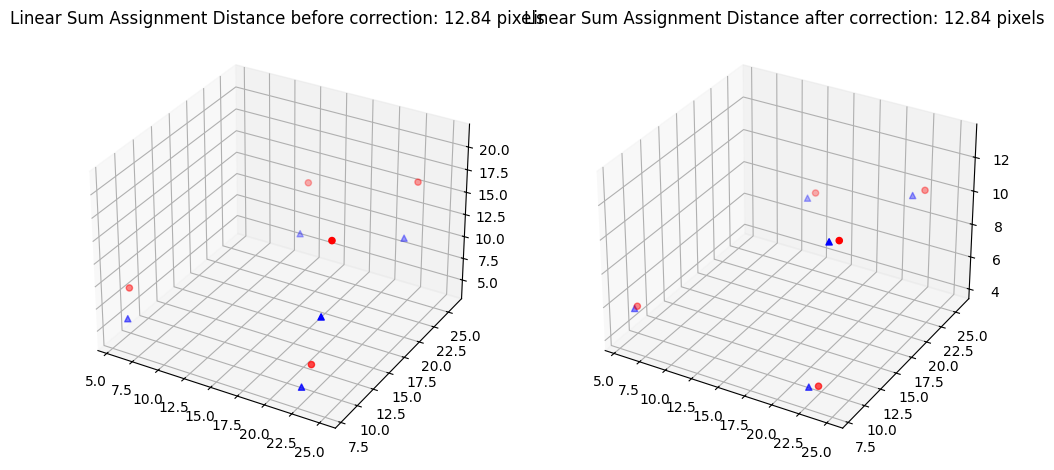

In [109]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create 3D plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Plot the points
ax[0].scatter(groundtruth.x, groundtruth.y, groundtruth.z, c='r', marker='o')
ax[0].scatter(bn_nuclei3.x, bn_nuclei3.y, bn_nuclei3.z, c='b', marker='^')
# Axis labels


# Set title
ax[0].set_title(f'Linear Sum Assignment Distance before correction: {lsa_:.2f} pixels')

# Plot the points after correction
ax[1].scatter(groundtruth_corrected.x, groundtruth_corrected.y, groundtruth_corrected.z, c='r', marker='o')
ax[1].scatter(bn_nuclei3.x, bn_nuclei3.y, bn_nuclei3.z, c='b', marker='^')
# Set title
ax[1].set_title(f'Linear Sum Assignment Distance after correction: {lsa_:.2f} pixels')

plt.show()
